In [1]:
import pandas as pd
import numpy as np

In [2]:
output_names = ['beckerestimation', 'csopII', 'DAT', 'gurcay2015estimation', 'jury', 'jury_TINY', 'pgg']

In [3]:
directory="../output/"
for dataset in output_names:
    csv_path = directory + dataset + '_output_conversation_level.csv'
    df = pd.read_csv(csv_path)
    print(dataset + ": " + str(df['discursive_diversity'].mean()))
    # mean_df = pd.DataFrame({'dataset': dataset, 'discursive mean': df['discursive_diversity'].mean()})

    # mean_df.to_csv('step1_DD_means.csv')



beckerestimation: 0.5549970523316429
csopII: 0.643433754406302
DAT: 0.5958520491707279
gurcay2015estimation: 0.5945824035668794
jury: 0.4269552462902284
jury_TINY: 0.3846901364054913
pgg: 0.5845007521581473


## Intuitive unit tests for DD

In [150]:
from discursive_diversity import *


In [151]:
vect_data = pd.read_csv("../embeddings/test_dd.csv")

In [152]:
chat_data = pd.read_csv("../data/raw_data/test_dd.csv")

In [153]:
get_DD(chat_data, vect_data)

,conversation_num,discursive_diversity
0,1,3.870704e-01
1,2,8.280833e-01
2,3,-2.220446e-16


# DD Over Time
The original DD paper makes a big deal about how DD changes over time. Can we see meaningful patterns?

In [234]:
## What about DD over time?
import matplotlib.pyplot as plt
import math

In [250]:
# this is in utils - copying here for ease of access lol
def preprocess_conversation_columns(df):
	# remove all special characters from df
	df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '', regex=True)
	
	# If data is grouped by batch/round, add a conversation num
	if {'batch_num', 'round_num'}.issubset(df.columns):
		df['conversation_num'] = df.groupby(['batch_num', 'round_num']).ngroup()
		df = df[df.columns.tolist()[-1:] + df.columns.tolist()[0:-1]] # make the new column first

	return(df)

In [267]:
def get_and_preprocess_chats(chat_path, vec_path):
    chat_data = pd.read_csv(chat_path)
    vec_data = pd.read_csv(vec_path)
    chat_data = preprocess_conversation_columns(chat_data)
    chat_data = pd.merge(chat_data, vec_data["message_embedding"], left_index=True, right_index=True)
    
    return chat_data, vec_data

In [285]:
# Assign chunk numbers to the chats within each conversation
def assign_chunk_nums(chat_data):

    # Calculate the total number of rows per conversation
    conversation_lengths = chat_data.groupby('conversation_num').size()
    num_conversations = chat_data['conversation_num'].nunique()

    # Calculate the chunk size based on the total number of conversations
    chunk_size = np.ceil(conversation_lengths / 11) # I found that using 10 in the bottom actually only generates 9 groups, so here I use 11 ... (weird)

    for i, group in chat_data.groupby('conversation_num'): # for each group
        chunk_num = 0
        counter = 0

        for chat_id in group.index.values: # iterate over the index values
            chat_data.at[chat_id, 'chunk_num'] = chunk_num

            counter += 1

            if counter == chunk_size[i] and chunk_num < 9: # assign any extras to the last chunk
                chunk_num += 1
                counter = 0

    return(chat_data)

In [281]:
def get_dd_results_by_chunk(chat_data, vector_data):
    dd_results = chat_data.groupby(['conversation_num', 'chunk_num']).apply(lambda x: get_DD(x, vector_data))
    dd_results = dd_results.reset_index(drop=True)
    dd_results['chunk_num'] = dd_results.groupby('conversation_num').cumcount() + 1

    return(dd_results)

In [253]:
# Plot the results
def plot_dd_results(dd_results):

    plt.figure(figsize=(12, 6))
    for conversation_num, group in dd_results.groupby('conversation_num'):
        plt.plot(group['chunk_num'], group['discursive_diversity'], label=f'Conversation {conversation_num}')

    plt.xlabel('Chunk Number (Each contains 10% of chats)')
    plt.ylabel('Discursive Diversity')
    plt.title('Discursive Diversity Over Time')
    plt.show()

## Juries

In [274]:
chat_juries, vect_juries = get_and_preprocess_chats("../data/raw_data/jury_conversations_with_outcome_var.csv", "../embeddings/jury_conversations_with_outcome_var.csv")

In [275]:
chat_juries = assign_chunk_nums(chat_juries)

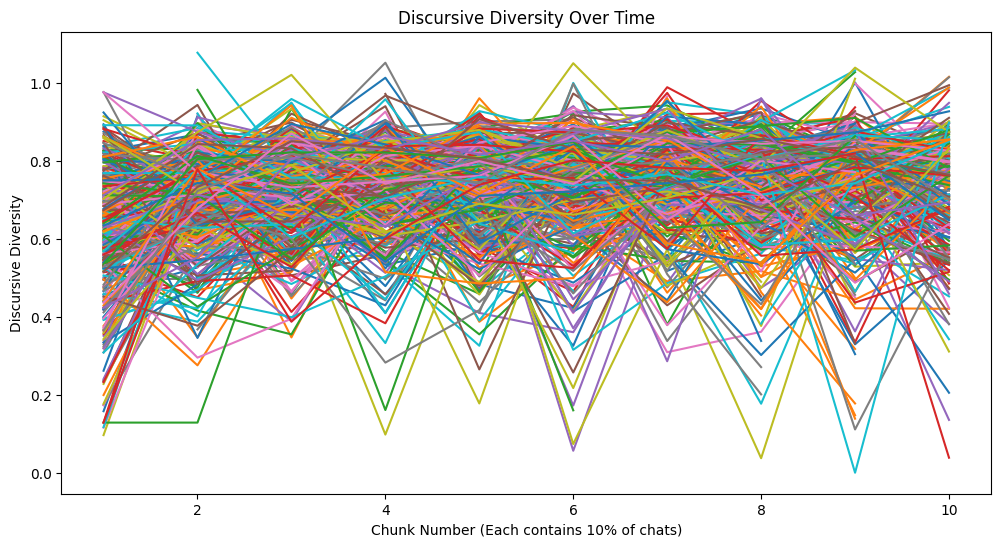

In [282]:
plot_dd_results(get_dd_results_by_chunk(chat_juries,vect_juries))

## CSOP II

In [283]:
chat_csop2, vect_csop2 = get_and_preprocess_chats("../data/raw_data/csopII_conversations_withblanks.csv", "../embeddings/csopII_conversations_withblanks.csv")

In [286]:
chat_csop2 = assign_chunk_nums(chat_csop2)

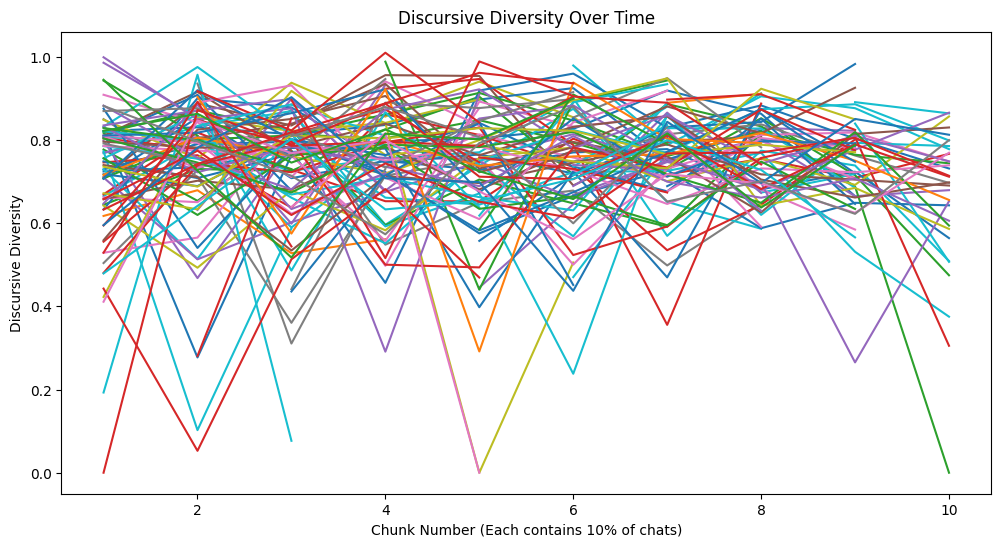

In [287]:
plot_dd_results(get_dd_results_by_chunk(chat_csop2, vect_csop2))